
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [ ]:
!pip install -q pybullet Box2D
!nvidia-smi

^C
✅ GPU اپل (MPS) در دسترس است. پردازنده روی 'mps' تنظیم شد.


Import necessary packages.

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal
import warnings
warnings.filterwarnings('ignore')
from gymnasium.wrappers import RecordVideo
import gymnasium as gym
import pybullet_envs_gymnasium    
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [54]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[max(0, i - 100): i+1]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [55]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False
        self.states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.next_states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.rewards = np.zeros((buffer_size, 1), dtype=np.float32)
        self.dones = np.zeros((buffer_size, 1), dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.ptr
        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.next_states[index] = state_
        self.dones[index] = done
        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0:
            self.is_full = True

    def load_batch(self, batch_size):
        max_mem = self.buffer_size if self.is_full else self.ptr
        replace = max_mem < batch_size
        batch_indices = np.random.choice(max_mem, batch_size, replace=replace)
        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.next_states[batch_indices]
        done = self.dones[batch_indices]
        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [56]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f'{ckpt_dir}/{name}_sac'
        self.fc1 = nn.Linear(state_dims + action_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)
        self.device = T.device('cuda:0' if T.cuda.is_available() else ('mps' if T.backends.mps.is_available() else 'cpu'))
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.beta)
        self.to(self.device)

    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f'{ckpt_dir}/{name}_sac'
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.mu = nn.Linear(fc2_dims, action_dims)
        self.sigma = nn.Linear(fc2_dims, action_dims)
        self.device = T.device('cuda:0' if T.cuda.is_available() else ('mps' if T.backends.mps.is_available() else 'cpu'))
        self.optimizer = T.optim.Adam(self.parameters(), lr=self.alpha)
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        sigma = F.softplus(self.sigma(x)) + 1e-6
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        dist = Normal(mu, sigma)
        u = dist.rsample() if reparameterize else dist.sample()
        action = T.tanh(u)
        log_probs = dist.log_prob(u) - T.log(1 - action.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(dim=1, keepdim=True)
        action = action * self.max_action
        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [57]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, warmup, reparam_noise_lim, name, ckpt_dir='tmp'):
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir
        model_name = f'{name}__gamma_{gamma}__alpha_{alpha}__beta_{beta}__fc1_{fc1_dim}__fc2_{fc2_dim}__bs_{batch_size}__buffer_{memory_size}__tau_{tau}__'
        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)
        self.memory = ReplayBuffer(memory_size, state_dims, action_dims)
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim, max_action, reparam_noise_lim, name='Actor', ckpt_dir=self.full_path)
        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name='Critic_1', ckpt_dir=self.full_path)
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name='Critic_2', ckpt_dir=self.full_path)
        self.target_critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name='Target_Critic_1', ckpt_dir=self.full_path)
        self.target_critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name='Target_Critic_2', ckpt_dir=self.full_path)
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        device = self.actor.device
        self.log_alpha = T.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = T.optim.Adam([self.log_alpha], lr=self.alpha)
        self.target_entropy = -T.tensor(action_dims, dtype=T.float32, device=device)

    def choose_action(self, state, deterministic=False, reparameterize=False):
        self.actor.eval()
        state = T.tensor(state, dtype=T.float32, device=self.actor.device).unsqueeze(0)
        if deterministic:
            with T.no_grad():
                mu, _ = self.actor(state)
                action = T.tanh(mu) * self.max_action
        else:
            with T.no_grad():
                action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)
        self.actor.train()
        return action.squeeze(0).cpu().numpy()

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self, batch_size):
        states, actions, rewards, states_, done = self.memory.load_batch(batch_size)
        device = self.actor.device
        states = T.tensor(states, dtype=T.float32, device=device)
        actions = T.tensor(actions, dtype=T.float32, device=device)
        rewards = T.tensor(rewards, dtype=T.float32, device=device).view(-1)
        states_ = T.tensor(states_, dtype=T.float32, device=device)
        done = T.tensor(done, dtype=T.float32, device=device).view(-1)
        return states, actions, rewards, states_, done

    def update_parameters(self, tau=None):
        tau = self.tau if tau is None else tau
        for t, s in zip(self.target_critic_1.parameters(), self.critic_1.parameters()):
            t.data.copy_(tau * s.data + (1.0 - tau) * t.data)
        for t, s in zip(self.target_critic_2.parameters(), self.critic_2.parameters()):
            t.data.copy_(tau * s.data + (1.0 - tau) * t.data)

    def save_model(self):
        T.save(self.log_alpha.detach().cpu(), os.path.join(self.full_path, 'alpha.pt'))
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        try:
            a = T.load(os.path.join(self.full_path, 'alpha.pt'), map_location=(lambda storage, loc: storage) if gpu_to_cpu else None)
            self.log_alpha.data.copy_(a.to(self.actor.device).log())
        except Exception:
            pass

    def learn(self):
        available = self.memory.buffer_size if self.memory.is_full else self.memory.ptr
        if available < self.batch_size:
            self.learn_iter += 1
            return
        states, actions, rewards, states_, done = self.load_batch(self.batch_size)
        alpha = self.log_alpha.exp()
        with T.no_grad():
            next_actions, next_log_probs = self.actor.sample_normal(states_, reparameterize=True)
            tq1 = self.target_critic_1(states_, next_actions).view(-1)
            tq2 = self.target_critic_2(states_, next_actions).view(-1)
            tmin = T.min(tq1, tq2)
            q_hat = rewards + self.gamma * (1.0 - done) * (tmin - alpha * next_log_probs.view(-1))
        q1_pred = self.critic_1(states, actions).view(-1)
        q2_pred = self.critic_2(states, actions).view(-1)
        critic_1_loss = 0.5 * F.mse_loss(q1_pred, q_hat)
        critic_2_loss = 0.5 * F.mse_loss(q2_pred, q_hat)
        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        (critic_1_loss + critic_2_loss).backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()
        new_actions, log_probs2 = self.actor.sample_normal(states, reparameterize=True)
        q1_new = self.critic_1(states, new_actions).view(-1)
        q2_new = self.critic_2(states, new_actions).view(-1)
        q_min_new = T.min(q1_new, q2_new)
        actor_loss = (alpha.detach() * log_probs2.view(-1) - q_min_new).mean()
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()
        alpha_loss = -(self.log_alpha * (log_probs2.detach() + self.target_entropy)).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.update_parameters(tau=self.tau)
        self.learn_iter += 1

## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [60]:
env_name = 'HalfCheetah-v4'
import os
dir = os.path.expanduser('~/Downloads')
n_games = 500
gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
memory_size = int(1e6)
batch_size = 256
tau = 0.005
warmup = 1000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/500 [00:00<?, ?it/s]

| Game:      0 | Score:    -207.63 | Best score:    -207.63 | Avg score    -207.63 | Learning iter:          0 |
| Game:      1 | Score:    -286.33 | Best score:    -207.63 | Avg score    -246.98 | Learning iter:       1000 |
| Game:      2 | Score:    -332.39 | Best score:    -207.63 | Avg score    -275.45 | Learning iter:       2000 |
| Game:      3 | Score:    -116.30 | Best score:    -207.63 | Avg score    -235.66 | Learning iter:       3000 |
| Game:      4 | Score:    -140.55 | Best score:    -207.63 | Avg score    -216.64 | Learning iter:       4000 |
| Game:      5 | Score:    -177.19 | Best score:    -207.63 | Avg score    -210.07 | Learning iter:       5000 |
| Game:      6 | Score:    -183.55 | Best score:    -206.28 | Avg score    -206.28 | Learning iter:       6000 |
| Game:      7 | Score:    -249.54 | Best score:    -206.28 | Avg score    -211.69 | Learning iter:       7000 |
| Game:      8 | Score:    -189.98 | Best score:    -206.28 | Avg score    -209.27 | Learning it

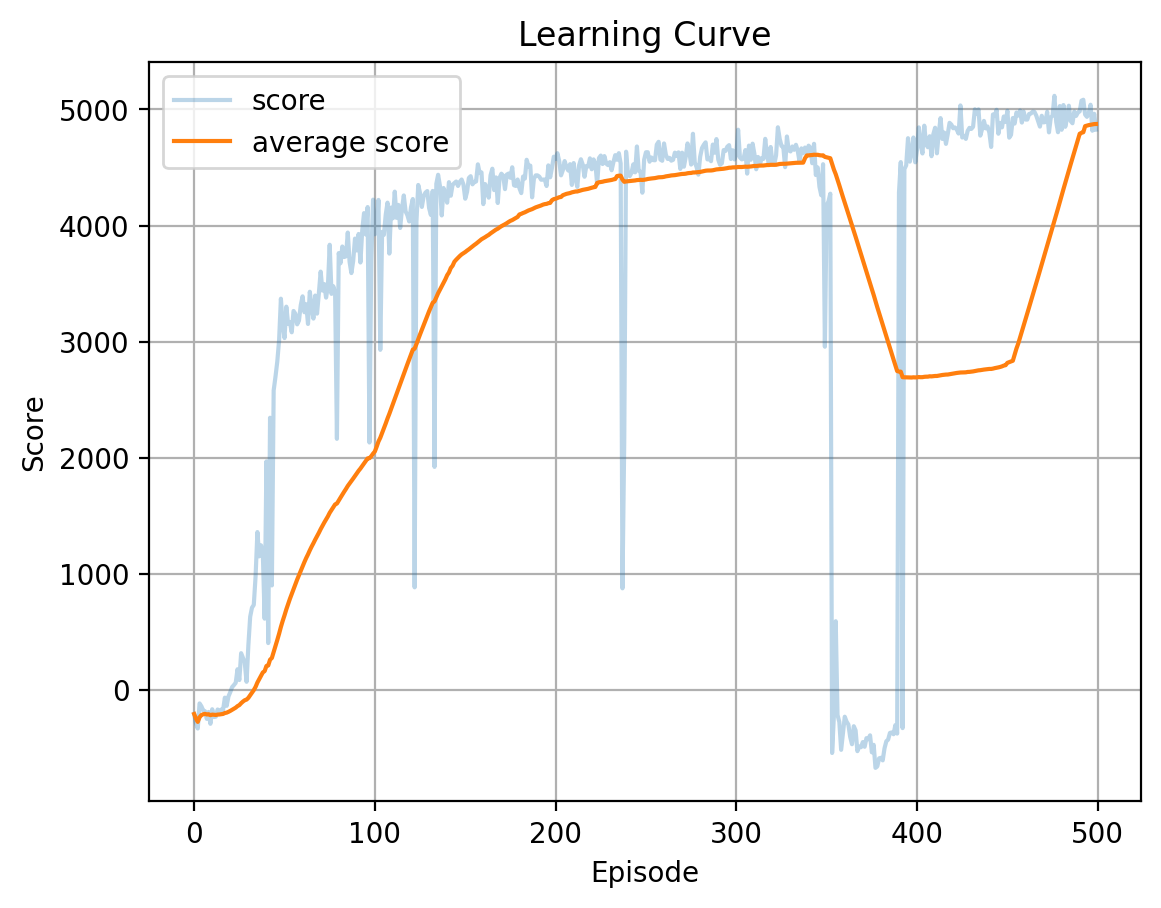

In [61]:
import os
os.environ["MUJOCO_GL"] = "glfw"
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)
env = gym.make(env_name, render_mode="rgb_array")
if record_video:
    try:
        env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                          episode_trigger=lambda ep: ep == n_games - 1)
    except Exception as e:
        print("⚠️ ضبط ویدیو غیرفعال شد:", e)
        record_video = False
state_dims = env.observation_space.shape[0]
action_dims = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
agent = Agent(
    gamma=gamma, alpha=alpha, beta=beta,
    state_dims=state_dims, action_dims=action_dims, max_action=max_action,
    fc1_dim=fc1_dim, fc2_dim=fc2_dim,
    memory_size=memory_size, batch_size=batch_size,
    tau=tau, warmup=warmup,
    reparam_noise_lim=reparam_noise_lim,
    name=env_name, ckpt_dir=dir
)
os.makedirs(agent.full_path, exist_ok=True)
scores = []
avg_scores = []
best_score = -np.inf
num_steps = 0
for game in trange(n_games):
    reset_out = env.reset()
    if isinstance(reset_out, tuple):
        state, _ = reset_out
    else:
        state = reset_out
    done = False
    score = 0.0
    while not done:
        if num_steps < warmup:
            action = env.action_space.sample()
        else:
            action = agent.choose_action(state, deterministic=False, reparameterize=False)
        step_out = env.step(action)
        if len(step_out) == 5:
            state_, reward, terminated, truncated, _ = step_out
            done = terminated or truncated
        else:
            state_, reward, done, _ = step_out
        agent.store_transition(state, action, reward, state_, float(done))
        if num_steps >= warmup:
            agent.learn()
        score += reward
        state = state_
        num_steps += 1
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)
    best_score = max(best_score, avg_score)
    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')
    if avg_score >= best_score:
        agent.save_model()
env.close()
plot_learning_curve(scores, agent.full_path)

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [62]:
from IPython.display import Video
import os
Video(os.path.join(dir, env_name, 'videos', f'rl-video-episode-{n_games-1}.mp4'), embed=True, width=600)